# Prediction of Real Estate Prices
Use two methods-machine learning and ARIMA to predict housing prices. And select the better one. What's more, the conclusion will provide user interface codes to realize automatic predictions of states' or cities' housing price

## Ingest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.plotly import plot_mpl
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from pylab import rcParams
import cufflinks as cf
init_notebook_mode(connected = True)
cf.go_offline()
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/noahgift/real_estate_ml/master/data/Zip_Zhvi_SingleFamilyResidence_2018.csv")

In [3]:
df.head()

RegionID  RegionName     City State                             Metro  \
0     84654       60657  Chicago    IL          Chicago-Naperville-Elgin   
1     91982       77494     Katy    TX  Houston-The Woodlands-Sugar Land   
2     84616       60614  Chicago    IL          Chicago-Naperville-Elgin   
3     93144       79936  El Paso    TX                           El Paso   
4     91940       77449     Katy    TX  Houston-The Woodlands-Sugar Land   

       CountyName  SizeRank   1996-04   1996-05   1996-06   ...     2018-03  \
0     Cook County         1  334200.0  335400.0  336500.0   ...     1037400   
1   Harris County         2  210400.0  212200.0  212200.0   ...      330400   
2     Cook County         3  498100.0  500900.0  503100.0   ...     1317900   
3  El Paso County         4   77300.0   77300.0   77300.0   ...      120800   
4   Harris County         5   95400.0   95600.0   95800.0   ...      175500   

   2018-04  2018-05  2018-06  2018-07  2018-08  2018-09  2018-10  2018-11  \
0  1038700  1041500  1042800  1042900  1044400  1047800  1049700  1048300   
1   332700   334500   335900   337000   338300   338400   336900   336000   
2  1321100  1325300  1323800  1321200  1320700  1319500  1318800  1319700   
3   121300   122200   123000   123600   124500   125600   126300   126800   
4   176400   176900   176900   177300   178000   178500   179300   180200   

   2018-12  
0  1047900  
1   336500  
2  1323300  
3   127400  
4   180700  

[5 rows x 280 columns]

## Exploratory Data Analysis

In [4]:
# Remove null values
df = df.dropna()

In [5]:
df.rename(columns={"RegionName":"ZipCode"}, inplace=True)
df["ZipCode"]=df["ZipCode"].map(lambda x: "{:.0f}".format(x))
df["RegionID"]=df["RegionID"].map(lambda x: "{:.0f}".format(x))
df.head()

RegionID ZipCode     City State                             Metro  \
0    84654   60657  Chicago    IL          Chicago-Naperville-Elgin   
1    91982   77494     Katy    TX  Houston-The Woodlands-Sugar Land   
2    84616   60614  Chicago    IL          Chicago-Naperville-Elgin   
3    93144   79936  El Paso    TX                           El Paso   
4    91940   77449     Katy    TX  Houston-The Woodlands-Sugar Land   

       CountyName  SizeRank   1996-04   1996-05   1996-06   ...     2018-03  \
0     Cook County         1  334200.0  335400.0  336500.0   ...     1037400   
1   Harris County         2  210400.0  212200.0  212200.0   ...      330400   
2     Cook County         3  498100.0  500900.0  503100.0   ...     1317900   
3  El Paso County         4   77300.0   77300.0   77300.0   ...      120800   
4   Harris County         5   95400.0   95600.0   95800.0   ...      175500   

   2018-04  2018-05  2018-06  2018-07  2018-08  2018-09  2018-10  2018-11  \
0  1038700  1041500  1042800  1042900  1044400  1047800  1049700  1048300   
1   332700   334500   335900   337000   338300   338400   336900   336000   
2  1321100  1325300  1323800  1321200  1320700  1319500  1318800  1319700   
3   121300   122200   123000   123600   124500   125600   126300   126800   
4   176400   176900   176900   177300   178000   178500   179300   180200   

   2018-12  
0  1047900  
1   336500  
2  1323300  
3   127400  
4   180700  

[5 rows x 280 columns]

### The USA Housing Price Trend

In [6]:
df_usa = df.loc[:,'1996-04':'2018-12']
df_usa = df_usa.transpose()
df_usa.head()

0         1         2        3        4        5         6      \
1996-04  334200.0  210400.0  498100.0  77300.0  95400.0  95000.0  152900.0   
1996-05  335400.0  212200.0  500900.0  77300.0  95600.0  95200.0  152700.0   
1996-06  336500.0  212200.0  503100.0  77300.0  95800.0  95400.0  152600.0   
1996-07  337600.0  210700.0  504600.0  77300.0  96100.0  95700.0  152400.0   
1996-08  338500.0  208300.0  505500.0  77400.0  96400.0  95900.0  152300.0   

            7         8         9        ...        15494    15496     15498  \
1996-04  216500.0  162000.0  766000.0    ...     562400.0  80800.0  135900.0   
1996-05  216700.0  162300.0  771100.0    ...     562800.0  80100.0  136300.0   
1996-06  216900.0  162600.0  776500.0    ...     562700.0  79400.0  136600.0   
1996-07  217000.0  163000.0  781900.0    ...     562400.0  78600.0  136900.0   
1996-08  217100.0  163400.0  787300.0    ...     562300.0  77900.0  137100.0   

           15499     15500     15502    15503    15504    15505     15507  
1996-04  78300.0  136200.0  182600.0  94600.0  92700.0  57100.0  176400.0  
1996-05  78300.0  136600.0  183700.0  94300.0  92500.0  57300.0  176300.0  
1996-06  78200.0  136800.0  184800.0  94000.0  92400.0  57500.0  176100.0  
1996-07  78200.0  136800.0  185800.0  93700.0  92200.0  57700.0  176000.0  
1996-08  78100.0  136700.0  186700.0  93400.0  92100.0  58000.0  175900.0  

[5 rows x 13254 columns]

In [7]:
usa_price = df_usa.mean(axis=1)
usa_price = pd.DataFrame(usa_price)
usa_price = usa_price.reset_index()
usa_price = usa_price.rename(columns={'index':'Time', 0:'Average Price'})
usa_price['Time'] = pd.to_datetime(usa_price['Time'])
usa_price.set_index('Time', inplace=True)
usa_price.head()

Average Price
Time                     
1996-04-01  119843.979176
1996-05-01  119964.886072
1996-06-01  120083.967104
1996-07-01  120200.022635
1996-08-01  120327.735023

In [8]:
usa_price.iplot(title="The USA Single Family Home Prices 1996-2018",
                    xTitle="Year",
                    yTitle="Sales Price",
                    shape=(12,1)
                    )

### The States' Housing Price

#### Compare 1996-2018 Average Housing Price 

In [9]:
df_state = df.copy()

In [10]:
df_state['row_mean'] = df_usa.mean(axis=0) 

In [11]:
df_state.head()

RegionID ZipCode     City State                             Metro  \
0    84654   60657  Chicago    IL          Chicago-Naperville-Elgin   
1    91982   77494     Katy    TX  Houston-The Woodlands-Sugar Land   
2    84616   60614  Chicago    IL          Chicago-Naperville-Elgin   
3    93144   79936  El Paso    TX                           El Paso   
4    91940   77449     Katy    TX  Houston-The Woodlands-Sugar Land   

       CountyName  SizeRank   1996-04   1996-05   1996-06      ...        \
0     Cook County         1  334200.0  335400.0  336500.0      ...         
1   Harris County         2  210400.0  212200.0  212200.0      ...         
2     Cook County         3  498100.0  500900.0  503100.0      ...         
3  El Paso County         4   77300.0   77300.0   77300.0      ...         
4   Harris County         5   95400.0   95600.0   95800.0      ...         

   2018-04  2018-05  2018-06  2018-07  2018-08  2018-09  2018-10  2018-11  \
0  1038700  1041500  1042800  1042900  1044400  1047800  1049700  1048300   
1   332700   334500   335900   337000   338300   338400   336900   336000   
2  1321100  1325300  1323800  1321200  1320700  1319500  1318800  1319700   
3   121300   122200   123000   123600   124500   125600   126300   126800   
4   176400   176900   176900   177300   178000   178500   179300   180200   

   2018-12       row_mean  
0  1047900  753125.641026  
1   336500  264351.648352  
2  1323300  984821.611722  
3   127400  102547.252747  
4   180700  128052.380952  

[5 rows x 281 columns]

In [12]:
df_state_price = df_state[['State', 'row_mean']]
df_state_avg_price = df_state_price.groupby(['State'], as_index=False).mean()
df_state_avg_price = df_state_avg_price.rename(columns={'State': 'Code', 'row_mean': 'State Housing Price'})
df_state_avg_price['State Housing Price'] = df_state_avg_price['State Housing Price'].round(2)
df_state_avg_price.head()

Code  State Housing Price
0   AK            251819.91
1   AL            127131.74
2   AR            109508.90
3   AZ            204791.24
4   CA            474905.63

In [13]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [14]:
us_state_code = pd.DataFrame.from_dict(us_state_abbrev, orient='index')
us_state_code = us_state_code.reset_index()
us_state_code = us_state_code.rename(columns={'index': 'State', 0: 'Code'})
df_state_avg_price = df_state_avg_price.merge(us_state_code, on='Code', how='inner')
df_state_avg_price['Description'] = df_state_avg_price['State'].map(str) + '-' + df_state_avg_price['State Housing Price'].map(str)
df_state_avg_price.head()

Code  State Housing Price       State           Description
0   AK            251819.91      Alaska      Alaska-251819.91
1   AL            127131.74     Alabama     Alabama-127131.74
2   AR            109508.90    Arkansas     Arkansas-109508.9
3   AZ            204791.24     Arizona     Arizona-204791.24
4   CA            474905.63  California  California-474905.63

In [15]:
data = dict(type = 'choropleth', 
            colorscale = 'Picnic', 
            locations = df_state_avg_price['Code'], 
            z = df_state_avg_price['State Housing Price'], 
            locationmode = 'USA-states', 
            text = df_state_avg_price['Description'], 
            marker = dict(line = dict(color = 'rgb(255, 255,255)', width = 2)),
            colorbar = {'title':"Housing Price"}
           )

layout = dict(title = 'The USA Housing Price',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )

choromap = go.Figure(data = [data], layout=layout)

iplot(choromap)

#### Compare Recent Housing Price

In [16]:
df_2018 = df.loc[:, '2018-01':'2018-12']
df_state = pd.DataFrame(df['State'])
df_recent = pd.concat([df_state, df_2018], axis=1)
df_recent['row_mean'] = df_recent.mean(axis=1) 
df_state_recent_price = df_recent[['State', 'row_mean']]
df_state_recent_avg_price = df_state_recent_price.groupby(['State'], as_index=False).mean()
df_state_recent_avg_price = df_state_recent_avg_price.rename(columns={'State': 'Code', 'row_mean': '2018 State Housing Price'})
df_state_recent_avg_price['2018 State Housing Price'] = df_state_recent_avg_price['2018 State Housing Price'].round(2)
df_state_recent_avg_price.head()

Code  2018 State Housing Price
0   AK                 332924.62
1   AL                 154973.35
2   AR                 143981.34
3   AZ                 281641.05
4   CA                 765847.93

In [17]:
df_state_recent_avg_price = df_state_recent_avg_price.merge(us_state_code, on='Code', how='inner')
df_state_recent_avg_price['Description'] = df_state_recent_avg_price['State'].map(str) + '-' + df_state_recent_avg_price['2018 State Housing Price'].map(str)
df_state_recent_avg_price.head()

Code  2018 State Housing Price       State           Description
0   AK                 332924.62      Alaska      Alaska-332924.62
1   AL                 154973.35     Alabama     Alabama-154973.35
2   AR                 143981.34    Arkansas    Arkansas-143981.34
3   AZ                 281641.05     Arizona     Arizona-281641.05
4   CA                 765847.93  California  California-765847.93

In [18]:
data = dict(type = 'choropleth', 
            colorscale = 'Picnic', 
            locations = df_state_recent_avg_price['Code'], 
            z = df_state_recent_avg_price['2018 State Housing Price'], 
            locationmode = 'USA-states', 
            text = df_state_recent_avg_price['Description'], 
            marker = dict(line = dict(color = 'rgb(255, 255,255)', width = 2)),
            colorbar = {'title':"2018 Housing Price"}
           )

layout = dict(title = 'The USA 2018 Housing Price',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )

choromap = go.Figure(data = [data], layout=layout)

iplot(choromap)

#### Housing Price Trend of Every State

##### All States Housing Price Trend

In [19]:
df_price = df.loc[:, '1996-04':'2018-12']
df_state = pd.DataFrame(df['State'])
df_state_price = pd.concat([df_state, df_price], axis=1)
df_state_price = df_state_price.rename(columns={'State':'Code'})
df_state_price.head()

Code   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09   1996-10  \
0   IL  334200.0  335400.0  336500.0  337600.0  338500.0  339500.0  340400.0   
1   TX  210400.0  212200.0  212200.0  210700.0  208300.0  205500.0  202500.0   
2   IL  498100.0  500900.0  503100.0  504600.0  505500.0  505700.0  505300.0   
3   TX   77300.0   77300.0   77300.0   77300.0   77400.0   77500.0   77600.0   
4   TX   95400.0   95600.0   95800.0   96100.0   96400.0   96700.0   96800.0   

    1996-11   1996-12   ...     2018-03  2018-04  2018-05  2018-06  2018-07  \
0  341300.0  342600.0   ...     1037400  1038700  1041500  1042800  1042900   
1  199800.0  198300.0   ...      330400   332700   334500   335900   337000   
2  504200.0  503600.0   ...     1317900  1321100  1325300  1323800  1321200   
3   77700.0   77700.0   ...      120800   121300   122200   123000   123600   
4   96800.0   96700.0   ...      175500   176400   176900   176900   177300   

   2018-08  2018-09  2018-10  2018-11  2018-12  
0  1044400  1047800  1049700  1048300  1047900  
1   338300   338400   336900   336000   336500  
2  1320700  1319500  1318800  1319700  1323300  
3   124500   125600   126300   126800   127400  
4   178000   178500   179300   180200   180700  

[5 rows x 274 columns]

In [20]:
df_state_price = df_state_price.merge(us_state_code, on='Code', how='inner')
df_state_price.head()

Code   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09   1996-10  \
0   IL  334200.0  335400.0  336500.0  337600.0  338500.0  339500.0  340400.0   
1   IL  498100.0  500900.0  503100.0  504600.0  505500.0  505700.0  505300.0   
2   IL  216500.0  216700.0  216900.0  217000.0  217100.0  217200.0  217500.0   
3   IL  122700.0  122800.0  122800.0  122700.0  122400.0  122000.0  121500.0   
4   IL  142600.0  143100.0  143400.0  143300.0  142900.0  142200.0  141300.0   

    1996-11   1996-12    ...     2018-04  2018-05  2018-06  2018-07  2018-08  \
0  341300.0  342600.0    ...     1038700  1041500  1042800  1042900  1044400   
1  504200.0  503600.0    ...     1321100  1325300  1323800  1321200  1320700   
2  217900.0  218600.0    ...      787700   788500   778400   763500   758400   
3  120900.0  120500.0    ...      474700   476100   477200   476400   475300   
4  140100.0  139000.0    ...      470500   472700   473300   470300   466800   

   2018-09  2018-10  2018-11  2018-12     State  
0  1047800  1049700  1048300  1047900  Illinois  
1  1319500  1318800  1319700  1323300  Illinois  
2   756500   749000   744600   749200  Illinois  
3   476200   476500   474900   474800  Illinois  
4   465700   465700   464900   464500  Illinois  

[5 rows x 275 columns]

In [21]:
df_state_price_trend = df_state_price.groupby(['State']).mean()
df_state_price_trend = df_state_price_trend.transpose()
df_state_price_trend.head()

State         Alabama         Alaska        Arizona      Arkansas  \
1996-04  85501.129944  129927.272727  116203.720930  70456.521739   
1996-05  85783.615819  130381.818182  116563.255814  70600.000000   
1996-06  86070.056497  130795.454545  116934.883721  70721.739130   
1996-07  86353.672316  131168.181818  117315.348837  70841.304348   
1996-08  86655.932203  131531.818182  117719.534884  70955.434783   

State       California       Colorado    Connecticut       Delaware  \
1996-04  202218.993929  151294.849785  157630.081301  126045.833333   
1996-05  202129.488291  151519.313305  157504.878049  126537.500000   
1996-06  202049.002602  151761.802575  157368.292683  127004.166667   
1996-07  201987.510841  152000.000000  157220.325203  127404.166667   
1996-08  201991.673894  152276.824034  157082.113821  127754.166667   

State          Florida       Georgia      ...        South Dakota  \
1996-04  107166.397849  95602.807018      ...        53663.636364   
1996-05  107223.790323  95973.333333      ...        53945.454545   
1996-06  107284.946237  96349.122807      ...        54227.272727   
1996-07  107341.801075  96732.631579      ...        54527.272727   
1996-08  107425.940860  97117.894737      ...        54863.636364   

State       Tennessee          Texas           Utah        Vermont  \
1996-04  70599.130435  116853.913043  162462.385321  100726.666667   
1996-05  70858.840580  116865.465839  162351.376147  100335.555556   
1996-06  71115.362319  116900.869565  162247.706422   99966.666667   
1996-07  71368.115942  116965.962733  162166.055046   99582.222222   
1996-08  71607.826087  117054.161491  162116.513761   99226.666667   

State         Virginia     Washington  West Virginia      Wisconsin  \
1996-04  125205.617978  140978.571429   66505.000000  113834.055728   
1996-05  125268.258427  141212.732919   66623.333333  113808.359133   
1996-06  125330.056180  141460.248447   66756.666667  113766.563467   
1996-07  125394.101124  141723.913043   66900.000000  113696.284830   
1996-08  125478.932584  142019.875776   67066.666667  113621.671827   

State          Wyoming  
1996-04  135184.210526  
1996-05  135236.842105  
1996-06  135221.052632  
1996-07  135136.842105  
1996-08  135047.368421  

[5 rows x 49 columns]

In [22]:
df_state_price_trend.iplot(title="The States' Single Family Home Prices 1996-2018",
                    xTitle="Year",
                    yTitle="Sales Price",
                    shape=(12,1)
                    )

##### One State Housing Price Trend

In [23]:
def main():
    print('Please input the state name you want to show')
    state_name = input()
    one_state_price_trend = pd.DataFrame(df_state_price_trend[state_name])
    state_usa_price_trend = pd.concat([one_state_price_trend, usa_price], axis=1) # usa_price is the above one
    state_usa_price_trend = state_usa_price_trend.rename(columns={'Average Price': 'USA Average Price'})
    state_usa_price_trend.iplot(title=f"The {state_name} Single Family Home Prices 1996-2018",
                    xTitle="Year",
                    yTitle="Sales Price",
                    shape=(12,1)
                    )
if __name__ == "__main__":
    main()

Please input the state name you want to show
California


##### One City Housing Price Trend

In [24]:
def main():
    print('Please input the city name you want to show')
    city_name = input()
    df_price = df.loc[:, '1996-04':'2018-12']
    df_city = pd.DataFrame(df['City'])
    df_city_price = pd.concat([df_city, df_price], axis=1)
    df_city_avg_price = df_city_price.groupby(['City']).mean()
    df_city_avg_price = df_city_avg_price.transpose()
    one_city_price_trend = pd.DataFrame(df_city_avg_price[city_name])
    city_usa_price_trend = pd.concat([one_city_price_trend, usa_price], axis=1) # usa_price is the above one
    city_usa_price_trend = city_usa_price_trend.rename(columns={'Average Price': 'USA Average Price'})
    
    city_usa_price_trend.iplot(title=f"The {city_name} Single Family Home Prices 1996-2018",
                    xTitle="Year",
                    yTitle="Sales Price",
                    shape=(12,1)
                    )
if __name__ == "__main__":
    main()

Please input the city name you want to show
New York


## Build up Model

### Machine Learning Model
In designing my machine learning model, I regard every time variables as independent variables. This is actually not a good way to deal with time series data but I just want to have a try.

In [25]:
X = df.loc[:,'1996-04':'2018-11']
y = df['2018-12']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [26]:
gau = GaussianNB()
gau.fit(X_train, y_train)
gau.score(X_test, y_test)

0.004903809883062995

### Time Series Prediction

#### The Whole Country Prediction

##### Preparation of Prediction

In [28]:
usa_price_trend = usa_price.copy()
usa_price_trend = usa_price_trend.round(2)
usa_price_trend.head()

Average Price
Time                     
1996-04-01      119843.98
1996-05-01      119964.89
1996-06-01      120083.97
1996-07-01      120200.02
1996-08-01      120327.74

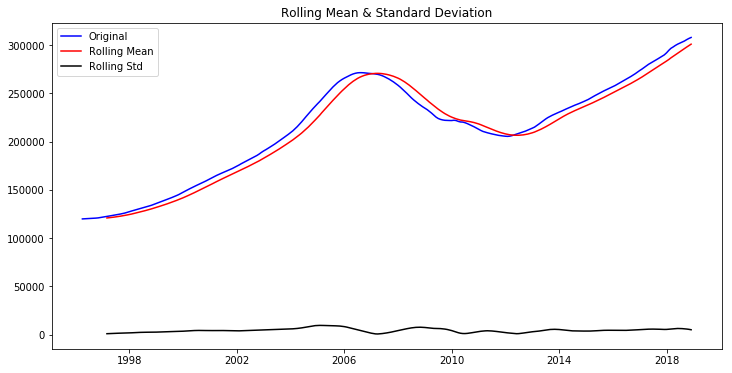

In [29]:
rolmean = usa_price_trend.rolling(12).mean()
rolstd = usa_price_trend.rolling(12).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(12, 6))
orig = plt.plot(usa_price_trend, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

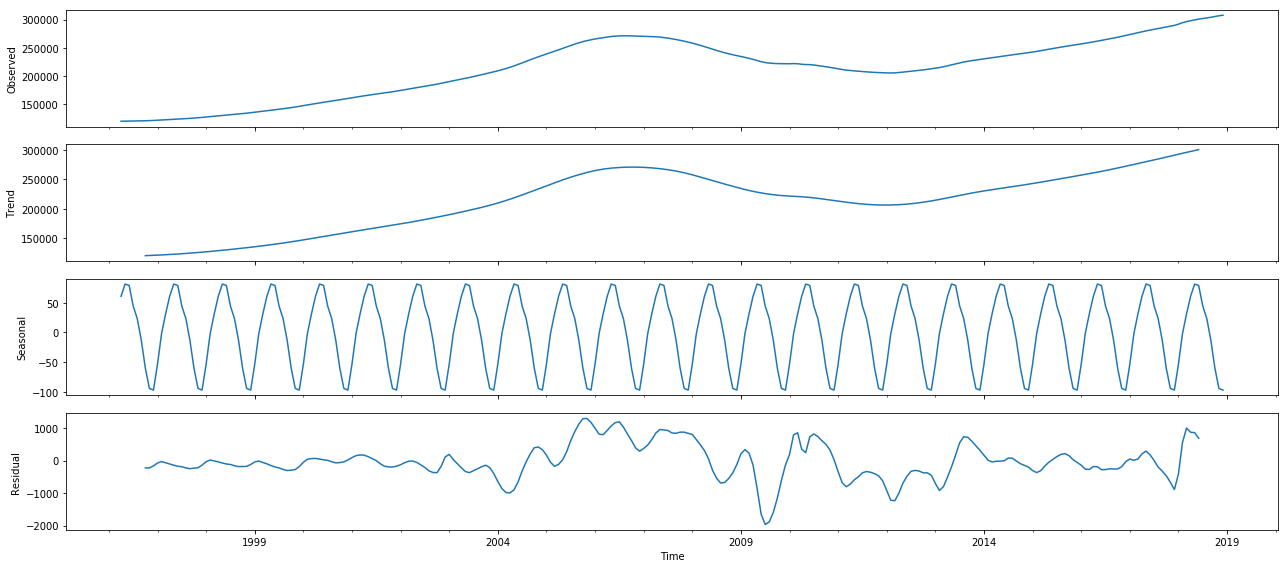

In [30]:
usa_decomposition = sm.tsa.seasonal_decompose(usa_price_trend, model='additive')
rcParams['figure.figsize'] = 18, 8
fig = usa_decomposition.plot()

We can observe evident seasonality. And I will use SARIMAX model to make predictions. SARIMAX in Python can automaticaly remove trend, seasonality, etc, making data stationary. 

##### Find Optimal Parameter of ARIMA Model

In [32]:
p = range(0, 2)
d = range(0, 2)
q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") 

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(usa_price_trend,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

The best combination is SARIMAX(1, 1, 1)x(1, 1, 1, 12)

In [33]:
model = sm.tsa.statespace.SARIMAX(usa_price_trend,
                                 order=(1,1,1), 
                                 seasonal_order=(1,1,1,12),   
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
result = model.fit()
print(result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      Average Price   No. Observations:                  273
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1629.836
Date:                            Tue, 29 Jan 2019   AIC                           3269.671
Time:                                    22:17:07   BIC                           3287.198
Sample:                                04-01-1996   HQIC                          3276.729
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9446      0.022     43.846      0.000       0.902       0.987
ma.L1          0.6594      0.033   

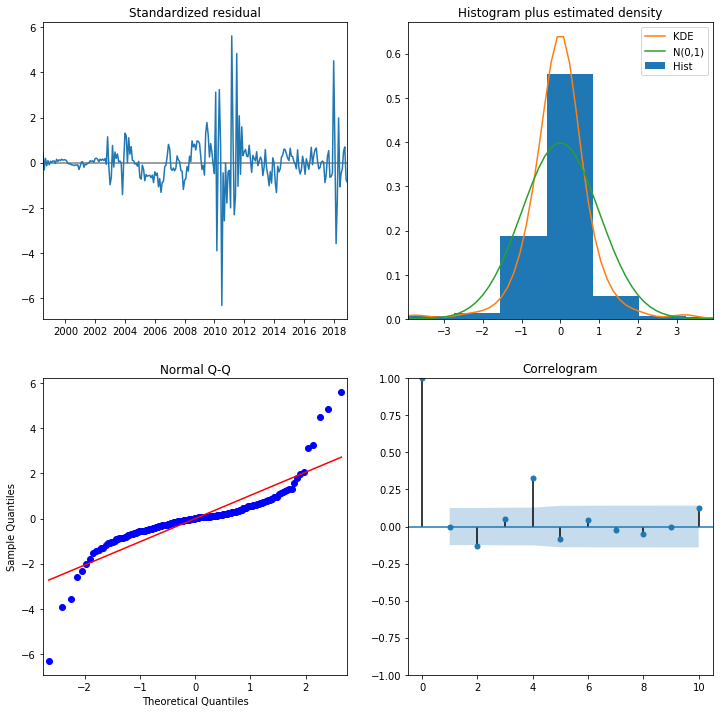

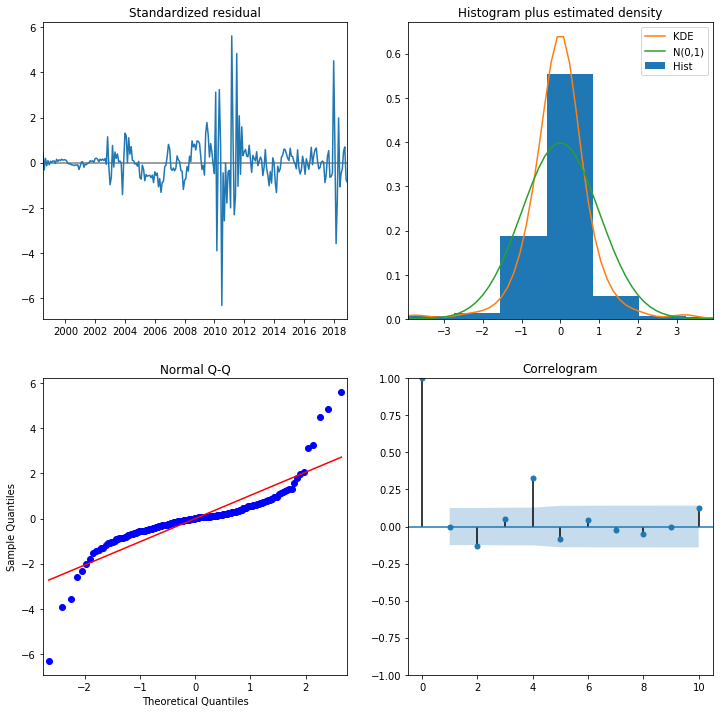

In [34]:
result.plot_diagnostics(figsize=(12, 12))

The residuals are normally distrbuted and don't show seasonality

##### Verify ARIMA Model

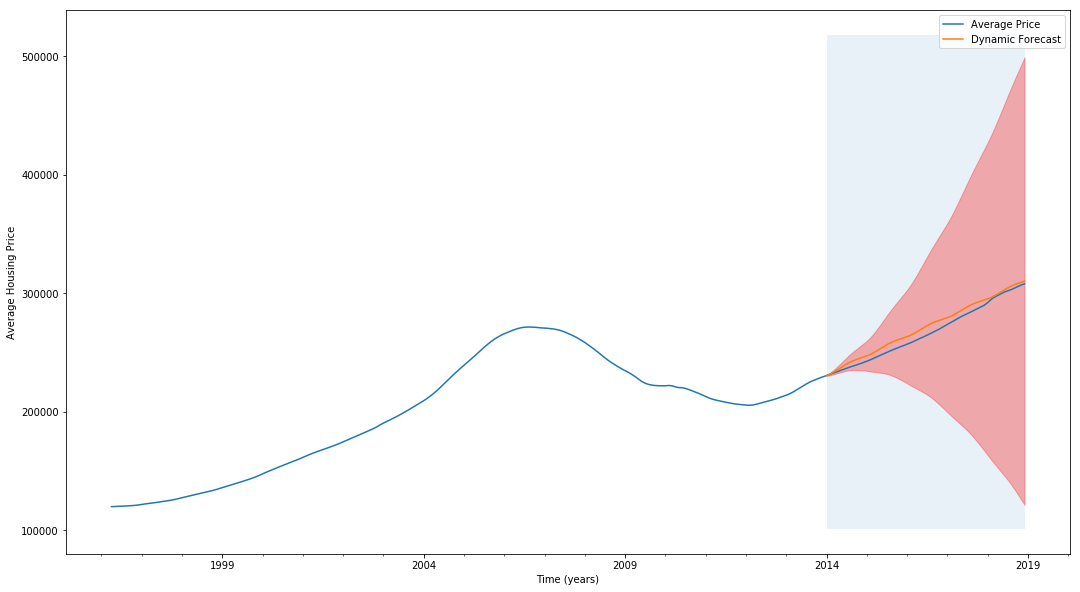

In [35]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf_int = pred_dynamic.conf_int()

axes = usa_price_trend['1996-04-01':].plot(label='Observed', figsize=(18, 10))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=axes)
axes.fill_between(pred_dynamic_conf_int.index,
                pred_dynamic_conf_int.iloc[:, 0],
                pred_dynamic_conf_int.iloc[:, 1], 
                color='r', 
                alpha=.3)
axes.fill_betweenx(axes.get_ylim(), 
                  pd.to_datetime('2014-01-01'), 
                  usa_price_trend.index[-1],
                  alpha=.1, zorder=-1)

axes.set_xlabel('Time (years)')
axes.set_ylabel('Average Housing Price')
plt.legend()

We can find that the predicted prices and original ones are similar(actually almost the same), which means SARIMAX model can predict very well.

##### Make Predictions

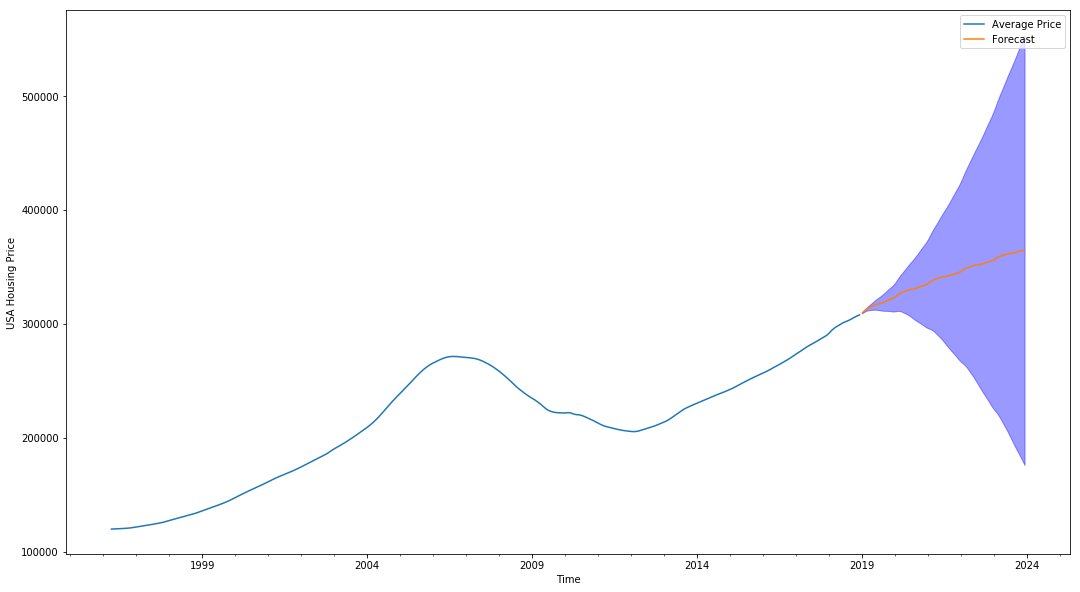

In [36]:
usa_forecast = results.get_forecast(steps= 60)
usa_forecast_conf_int = usa_forecast.conf_int()

axes = usa_price_trend.plot(label='Observed', figsize=(18, 10))
usa_forecast.predicted_mean.plot(ax=axes, label='Forecast')
axes.fill_between(usa_forecast_conf_int.index,
                 usa_forecast_conf_int.iloc[:, 0],
                 usa_forecast_conf_int.iloc[:, 1], color='b', alpha=.4)
axes.set_xlabel('Time')
axes.set_ylabel('USA Housing Price')
plt.legend()

#### Specific State Prediction

##### Preparation of Prediction

In [37]:
df_state_price_trend.head()

State         Alabama         Alaska        Arizona      Arkansas  \
1996-04  85501.129944  129927.272727  116203.720930  70456.521739   
1996-05  85783.615819  130381.818182  116563.255814  70600.000000   
1996-06  86070.056497  130795.454545  116934.883721  70721.739130   
1996-07  86353.672316  131168.181818  117315.348837  70841.304348   
1996-08  86655.932203  131531.818182  117719.534884  70955.434783   

State       California       Colorado    Connecticut       Delaware  \
1996-04  202218.993929  151294.849785  157630.081301  126045.833333   
1996-05  202129.488291  151519.313305  157504.878049  126537.500000   
1996-06  202049.002602  151761.802575  157368.292683  127004.166667   
1996-07  201987.510841  152000.000000  157220.325203  127404.166667   
1996-08  201991.673894  152276.824034  157082.113821  127754.166667   

State          Florida       Georgia      ...        South Dakota  \
1996-04  107166.397849  95602.807018      ...        53663.636364   
1996-05  107223.790323  95973.333333      ...        53945.454545   
1996-06  107284.946237  96349.122807      ...        54227.272727   
1996-07  107341.801075  96732.631579      ...        54527.272727   
1996-08  107425.940860  97117.894737      ...        54863.636364   

State       Tennessee          Texas           Utah        Vermont  \
1996-04  70599.130435  116853.913043  162462.385321  100726.666667   
1996-05  70858.840580  116865.465839  162351.376147  100335.555556   
1996-06  71115.362319  116900.869565  162247.706422   99966.666667   
1996-07  71368.115942  116965.962733  162166.055046   99582.222222   
1996-08  71607.826087  117054.161491  162116.513761   99226.666667   

State         Virginia     Washington  West Virginia      Wisconsin  \
1996-04  125205.617978  140978.571429   66505.000000  113834.055728   
1996-05  125268.258427  141212.732919   66623.333333  113808.359133   
1996-06  125330.056180  141460.248447   66756.666667  113766.563467   
1996-07  125394.101124  141723.913043   66900.000000  113696.284830   
1996-08  125478.932584  142019.875776   67066.666667  113621.671827   

State          Wyoming  
1996-04  135184.210526  
1996-05  135236.842105  
1996-06  135221.052632  
1996-07  135136.842105  
1996-08  135047.368421  

[5 rows x 49 columns]

In [38]:
df_state_price_trend = df_state_price_trend.round(2)
df_state_price_trend.head()

State     Alabama     Alaska    Arizona  Arkansas  California   Colorado  \
1996-04  85501.13  129927.27  116203.72  70456.52   202218.99  151294.85   
1996-05  85783.62  130381.82  116563.26  70600.00   202129.49  151519.31   
1996-06  86070.06  130795.45  116934.88  70721.74   202049.00  151761.80   
1996-07  86353.67  131168.18  117315.35  70841.30   201987.51  152000.00   
1996-08  86655.93  131531.82  117719.53  70955.43   201991.67  152276.82   

State    Connecticut   Delaware    Florida   Georgia    ...      South Dakota  \
1996-04    157630.08  126045.83  107166.40  95602.81    ...          53663.64   
1996-05    157504.88  126537.50  107223.79  95973.33    ...          53945.45   
1996-06    157368.29  127004.17  107284.95  96349.12    ...          54227.27   
1996-07    157220.33  127404.17  107341.80  96732.63    ...          54527.27   
1996-08    157082.11  127754.17  107425.94  97117.89    ...          54863.64   

State    Tennessee      Texas       Utah    Vermont   Virginia  Washington  \
1996-04   70599.13  116853.91  162462.39  100726.67  125205.62   140978.57   
1996-05   70858.84  116865.47  162351.38  100335.56  125268.26   141212.73   
1996-06   71115.36  116900.87  162247.71   99966.67  125330.06   141460.25   
1996-07   71368.12  116965.96  162166.06   99582.22  125394.10   141723.91   
1996-08   71607.83  117054.16  162116.51   99226.67  125478.93   142019.88   

State    West Virginia  Wisconsin    Wyoming  
1996-04       66505.00  113834.06  135184.21  
1996-05       66623.33  113808.36  135236.84  
1996-06       66756.67  113766.56  135221.05  
1996-07       66900.00  113696.28  135136.84  
1996-08       67066.67  113621.67  135047.37  

[5 rows x 49 columns]

In [39]:
ca_price_trend = pd.DataFrame(df_state_price_trend['California'])
ca_price_trend = ca_price_trend.reset_index()
ca_price_trend['index'] = pd.to_datetime(ca_price_trend['index'])
ca_price_trend = ca_price_trend.set_index('index')
ca_price_trend.head()

California
index                 
1996-04-01   202218.99
1996-05-01   202129.49
1996-06-01   202049.00
1996-07-01   201987.51
1996-08-01   201991.67

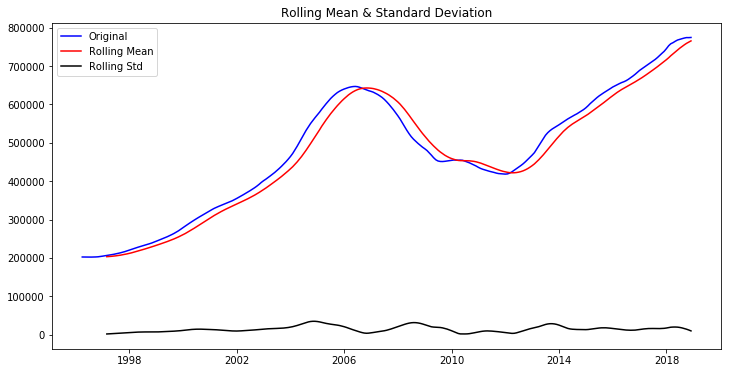

In [40]:
rolmean = ca_price_trend.rolling(12).mean()
rolstd = ca_price_trend.rolling(12).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(12, 6))
orig = plt.plot(ca_price_trend, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

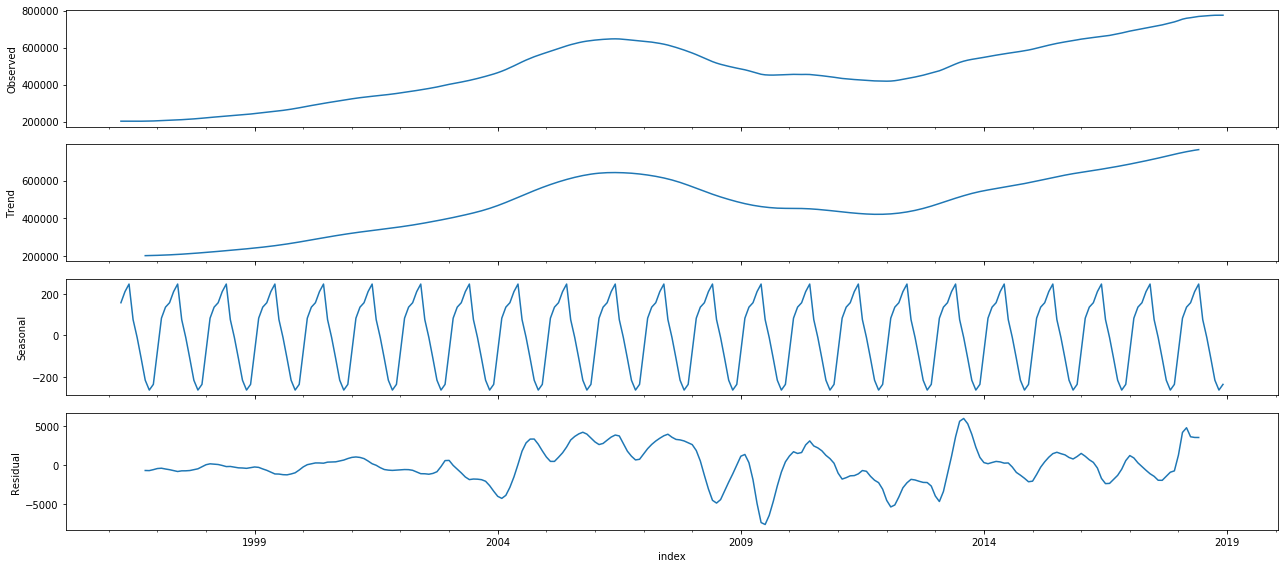

In [41]:
ca_decomposition = sm.tsa.seasonal_decompose(ca_price_trend, model='additive')
rcParams['figure.figsize'] = 18, 8
fig = ca_decomposition.plot()

##### Find Optimal Parameter of ARIMA Model

In [42]:
p = range(0, 2)
d = range(0, 2)
q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") 

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ca_price_trend,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

The best combination is SARIMAX(1, 1, 1)x(1, 1, 1, 12)

In [43]:
model = sm.tsa.statespace.SARIMAX(ca_price_trend,
                                 order=(1,1,1), 
                                 seasonal_order=(1,1,1,12),   
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
result = model.fit()
print(result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         California   No. Observations:                  273
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1915.301
Date:                            Tue, 29 Jan 2019   AIC                           3840.602
Time:                                    22:18:03   BIC                           3858.129
Sample:                                04-01-1996   HQIC                          3847.659
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9546      0.022     44.394      0.000       0.912       0.997
ma.L1          0.7615      0.040   

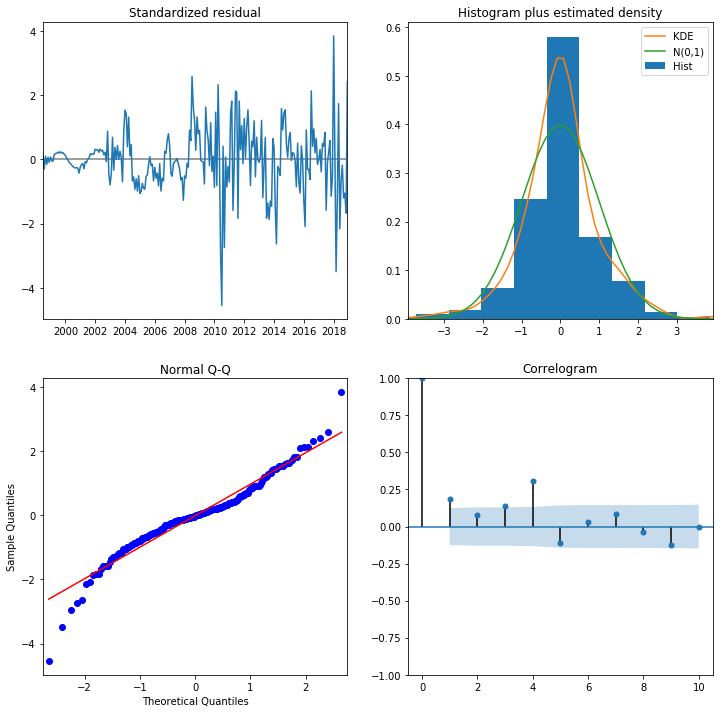

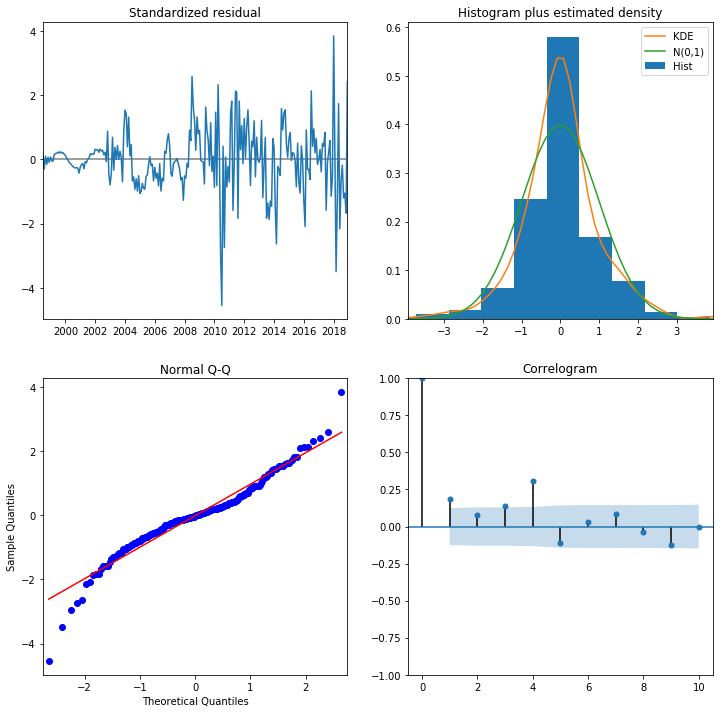

In [44]:
result.plot_diagnostics(figsize=(12, 12))

##### Verify ARIMA Model

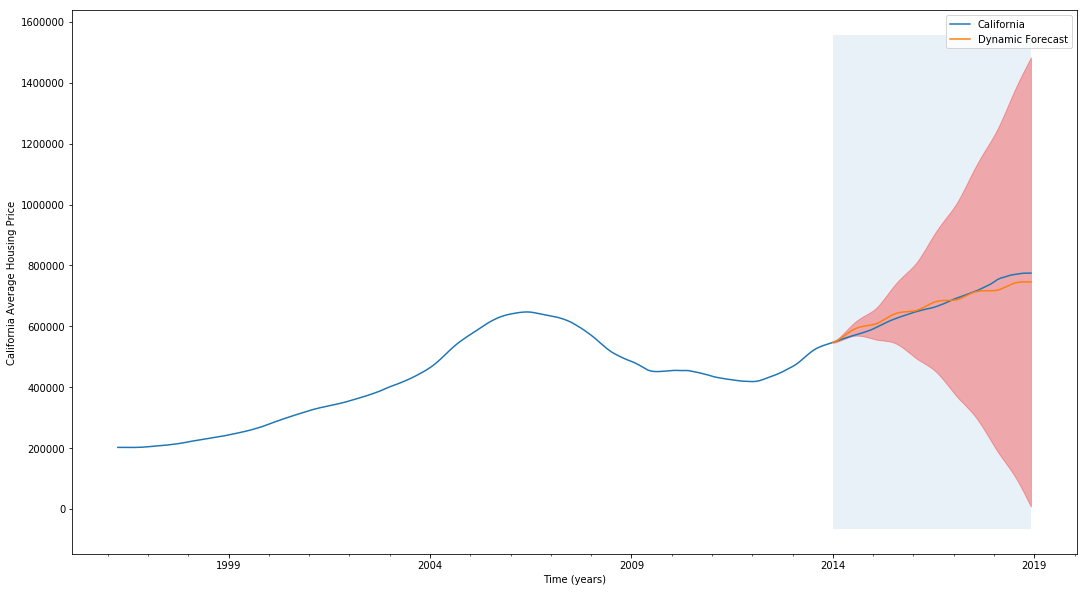

In [45]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf_int = pred_dynamic.conf_int()

axes = ca_price_trend['1996-04-01':].plot(label='Observed', figsize=(18, 10))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=axes)
axes.fill_between(pred_dynamic_conf_int.index,
                pred_dynamic_conf_int.iloc[:, 0],
                pred_dynamic_conf_int.iloc[:, 1], 
                color='r', 
                alpha=.3)
axes.fill_betweenx(axes.get_ylim(), 
                  pd.to_datetime('2014-01-01'), 
                  ca_price_trend.index[-1],
                  alpha=.1, zorder=-1)

axes.set_xlabel('Time (years)')
axes.set_ylabel('California Average Housing Price')
plt.legend()

##### Make Predictions

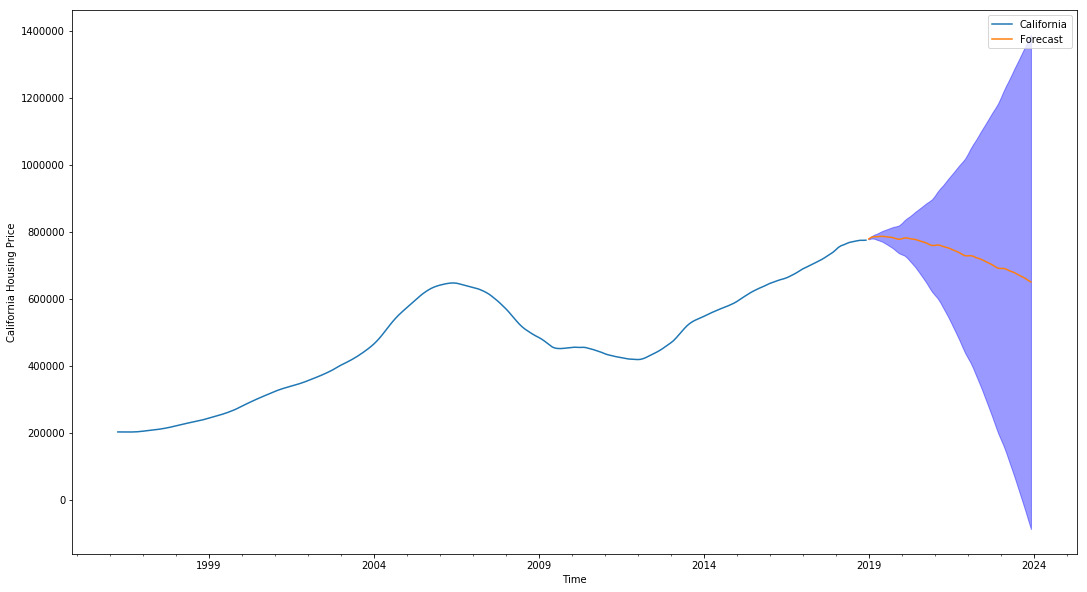

In [47]:
ca_forecast = results.get_forecast(steps= 60)
ca_forecast_conf_int = ca_forecast.conf_int()

axes = ca_price_trend.plot(label='Observed', figsize=(18, 10))
ca_forecast.predicted_mean.plot(ax=axes, label='Forecast')
axes.fill_between(ca_forecast_conf_int.index,
                 ca_forecast_conf_int.iloc[:, 0],
                 ca_forecast_conf_int.iloc[:, 1], color='b', alpha=.4)
axes.set_xlabel('Time')
axes.set_ylabel('California Housing Price')
plt.legend()

## Conclusion: User Interface
In this part, I want to design automatic predictions of every state and city. Whenever you input the state or city you want to check, it will show you respective results. What's more, the automatic presentations of historical housing price have been shown above.

### State Housing Price Prediction

Please input the state name you want to show
California


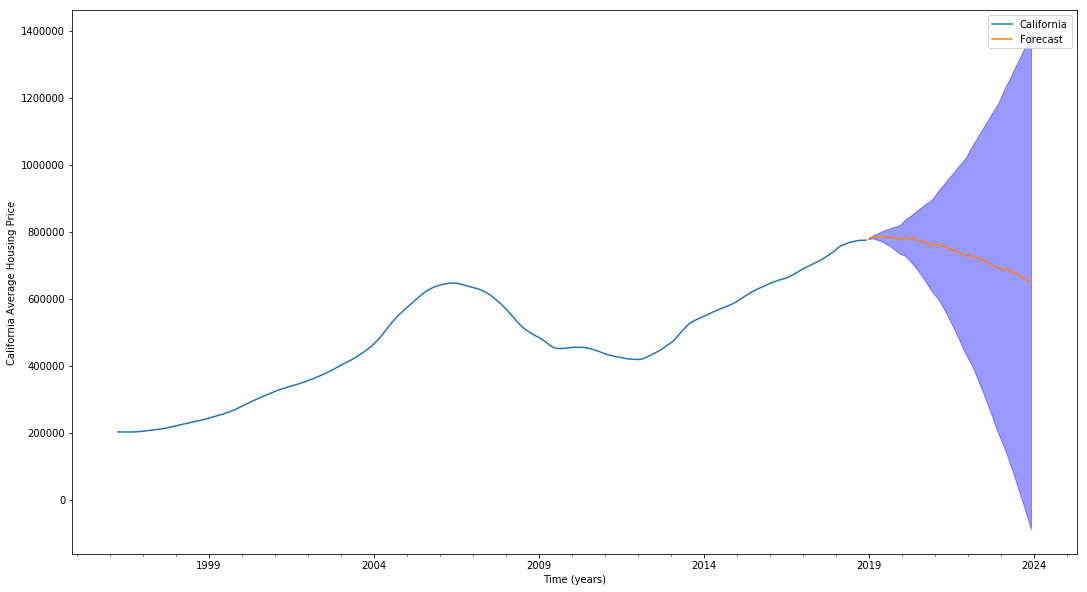

In [52]:
def main():
    print('Please input the state name you want to show')
    state_name = input()
    one_state_price_trend = pd.DataFrame(df_state_price_trend[state_name])
    one_state_price_trend = one_state_price_trend.reset_index()
    one_state_price_trend['index'] = pd.to_datetime(one_state_price_trend['index'])
    one_state_price_trend = one_state_price_trend.set_index('index')
    # Build up ARIMA model
    model = sm.tsa.statespace.SARIMAX(one_state_price_trend,
                                 order=(1,1,1), 
                                 seasonal_order=(1,1,1,12),   
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
    one_state_forecast = results.get_forecast(steps= 60)
    one_state_forecast_conf_int = one_state_forecast.conf_int()

    axes = one_state_price_trend.plot(label='Observed', figsize=(18, 10))
    one_state_forecast.predicted_mean.plot(ax=axes, label='Forecast')
    axes.fill_between(one_state_forecast_conf_int.index,
                 one_state_forecast_conf_int.iloc[:, 0],
                 one_state_forecast_conf_int.iloc[:, 1], color='b', alpha=.4)

    axes.set_xlabel('Time (years)')
    axes.set_ylabel(f'{state_name} Average Housing Price')
    plt.legend()

if __name__ == "__main__":
    main()

### City Housing Price Prediction

Please input the city name you want to show
New York


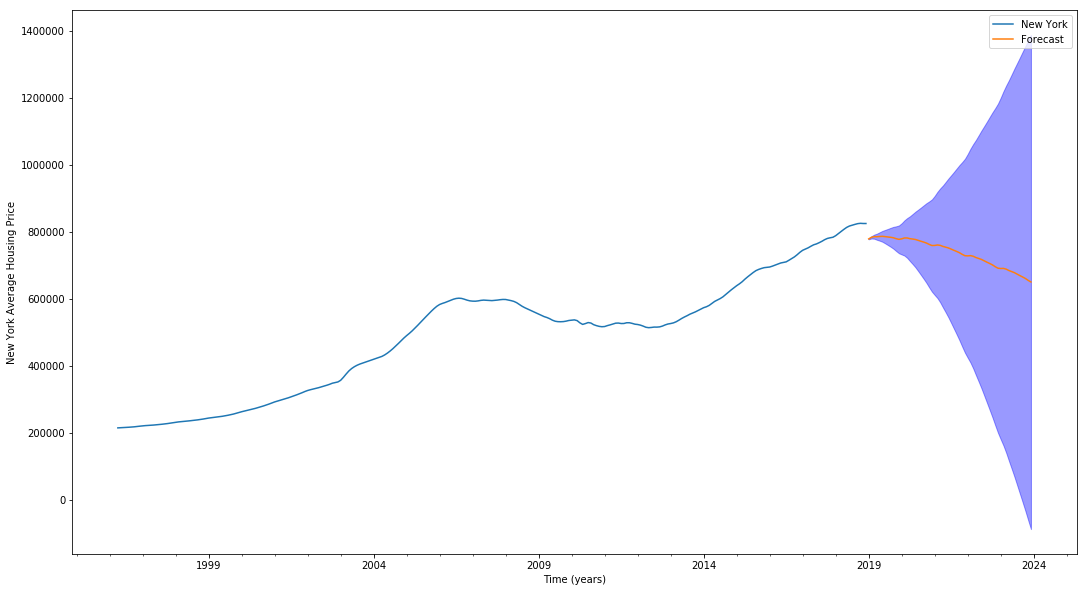

In [51]:
def main():
    print('Please input the city name you want to show')
    city_name = input()
    df_price = df.loc[:, '1996-04':'2018-12']
    df_city = pd.DataFrame(df['City'])
    df_city_price = pd.concat([df_city, df_price], axis=1)
    df_city_avg_price = df_city_price.groupby(['City']).mean()
    df_city_avg_price = df_city_avg_price.transpose()
    one_city_price_trend = pd.DataFrame(df_city_avg_price[city_name])
    one_city_price_trend = one_city_price_trend.reset_index()
    one_city_price_trend['index'] = pd.to_datetime(one_city_price_trend['index'])
    one_city_price_trend = one_city_price_trend.set_index('index')
    # Build up ARIMA model
    model = sm.tsa.statespace.SARIMAX(one_city_price_trend,
                                 order=(1,1,1), 
                                 seasonal_order=(1,1,1,12),   
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
    result = model.fit()
    # Make predictions and get confidence interval
    one_city_forecast = results.get_forecast(steps= 60)
    one_city_forecast_conf_int = one_city_forecast.conf_int()

    axes = one_city_price_trend.plot(label='Observed', figsize=(18, 10))
    one_city_forecast.predicted_mean.plot(ax=axes, label='Forecast')
    axes.fill_between(one_city_forecast_conf_int.index,
                 one_city_forecast_conf_int.iloc[:, 0],
                 one_city_forecast_conf_int.iloc[:, 1], color='b', alpha=.4)
    axes.set_xlabel('Time')
    axes.set_ylabel('USA Housing Price')
    plt.legend()

    axes.set_xlabel('Time (years)')
    axes.set_ylabel(f'{city_name} Average Housing Price')
    plt.legend()

if __name__ == "__main__":
    main()

We can see that for time series data, ARIMA performs better than machine learning and can provide more accurate predictions. And by using these interactive codes, you can get historical information and future predictions of specific state or city.